In [14]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Optional: make plots appear inline
%matplotlib inline

In [20]:
from google.colab import files

# Upload train.csv and test.csv
uploaded = files.upload()

Saving gender_submission.csv to gender_submission.csv
Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [21]:
from google.colab import files
import io

# If you just uploaded the files, they are in 'uploaded' dictionary
uploaded = files.upload()  # Upload train.csv and test.csv together

# Get the exact uploaded file names
print("Uploaded files:", uploaded.keys())

# Assign filenames dynamically to avoid KeyError
train_filename = [f for f in uploaded.keys() if "train" in f.lower()][0]
test_filename = [f for f in uploaded.keys() if "test" in f.lower()][0]

# Load CSV files into pandas
train_data = pd.read_csv(io.BytesIO(uploaded[train_filename]))
test_data = pd.read_csv(io.BytesIO(uploaded[test_filename]))

# Check the first few rows
train_data.head()

Saving test.csv to test (2).csv
Saving train.csv to train (2).csv
Uploaded files: dict_keys(['test (2).csv', 'train (2).csv'])


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
# Dataset information
print(train_data.info())

# Count missing values
print("\nMissing values per column:")
print(train_data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Em

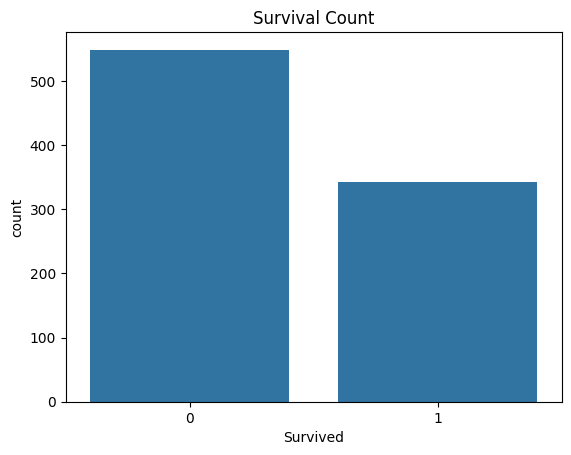

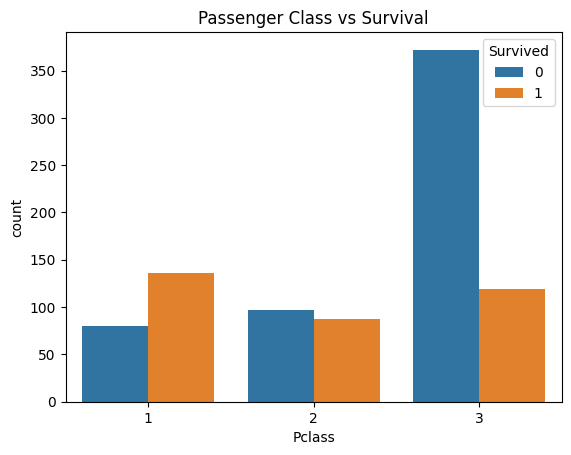

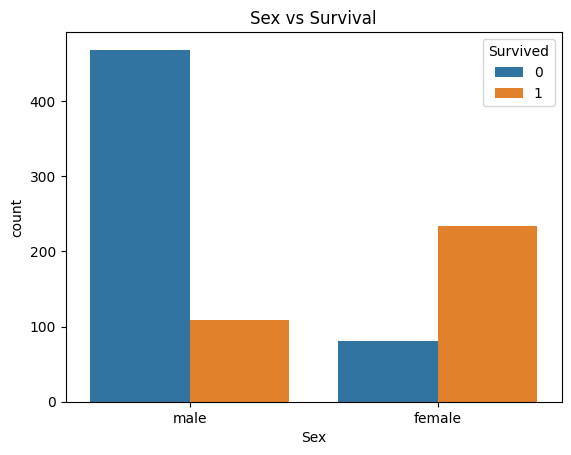

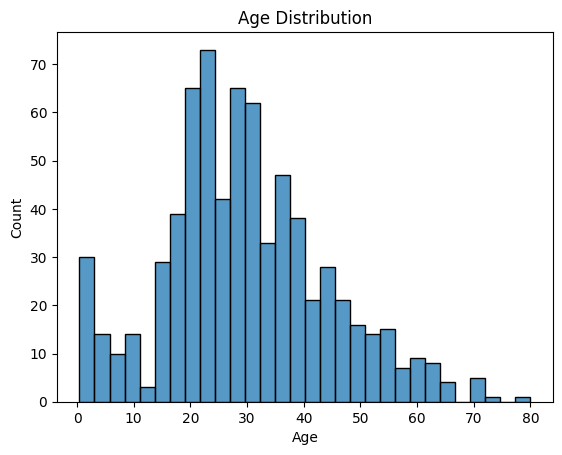

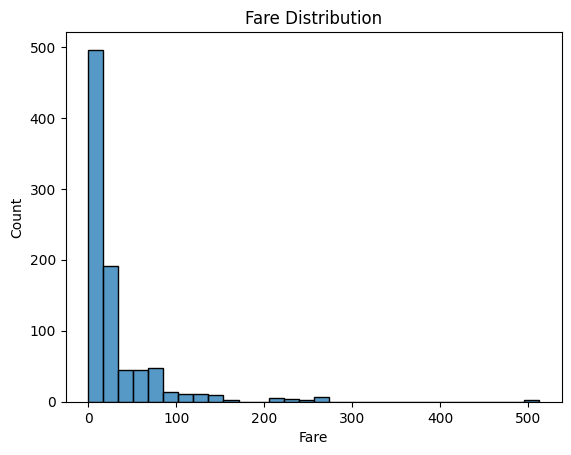

In [23]:
# Survival count
sns.countplot(x='Survived', data=train_data)
plt.title('Survival Count')
plt.show()

# Pclass vs Survival
sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.title('Passenger Class vs Survival')
plt.show()

# Sex vs Survival
sns.countplot(x='Sex', hue='Survived', data=train_data)
plt.title('Sex vs Survival')
plt.show()

# Age distribution
sns.histplot(train_data['Age'].dropna(), bins=30)
plt.title('Age Distribution')
plt.show()

# Fare distribution
sns.histplot(train_data['Fare'], bins=30)
plt.title('Fare Distribution')
plt.show()

In [24]:
# Fill missing Age with median
imputer = SimpleImputer(strategy='median')
train_data['Age'] = imputer.fit_transform(train_data[['Age']])
test_data['Age'] = imputer.transform(test_data[['Age']])

# Fill missing Embarked with mode
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

# Fill missing Fare in test set
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

# Encode categorical variables
le = LabelEncoder()
train_data['Sex'] = le.fit_transform(train_data['Sex'])
test_data['Sex'] = le.transform(test_data['Sex'])

train_data['Embarked'] = le.fit_transform(train_data['Embarked'])
test_data['Embarked'] = le.transform(test_data['Embarked'])

/tmp/ipython-input-1914746832.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)
/tmp/ipython-input-1914746832.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [31]:
# Create FamilySize
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

# Extract Title from Name
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify rare titles
rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
train_data['Title'] = train_data['Title'].replace(rare_titles, 'Rare')
test_data['Title'] = test_data['Title'].replace(rare_titles, 'Rare')

# Map common titles
title_mapping = {'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'}
train_data['Title'] = train_data['Title'].replace(title_mapping)
test_data['Title'] = test_data['Title'].replace(title_mapping)

# Show table of survival by title
train_data[['Title','Survived']].groupby('Title').mean()

<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1019337612.py:6: SyntaxWarning: invalid escape sequence '\.'
  train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
/tmp/ipython-input-1019337612.py:7: SyntaxWarning: invalid escape sequence '\.'
  test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


In [25]:
# Select features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train_data[features]
y = train_data['Survived']

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_X = scaler.transform(test_data[features])

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (712, 7)
Validation set shape: (179, 7)


In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (712, 7)
Validation set shape: (179, 7)


In [28]:
# Initialize and train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

In [32]:
# Info
train_data.info()

# Summary statistics
train_data.describe()

# Show missing values in a table
missing_values = pd.DataFrame(train_data.isnull().sum(), columns=['Missing Values'])
missing_values['% of Total'] = (missing_values['Missing Values']/len(train_data))*100
missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    int64  
 12  FamilySize   891 non-null    int64  
 13  Title        891 non-null    object 
dtypes: float64(2), int64(8), object(4)
memory usage: 97.6+ KB


,Missing Values,% of Total
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


Validation Accuracy: 0.8156424581005587


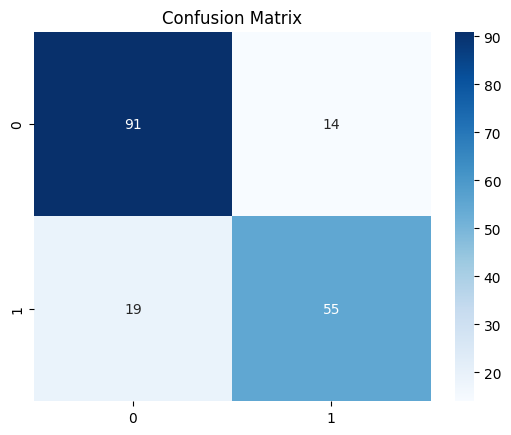

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179



In [29]:
# Accuracy
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_val, y_pred))

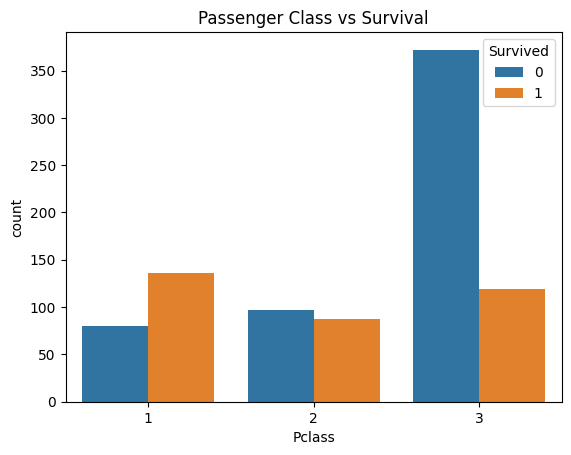

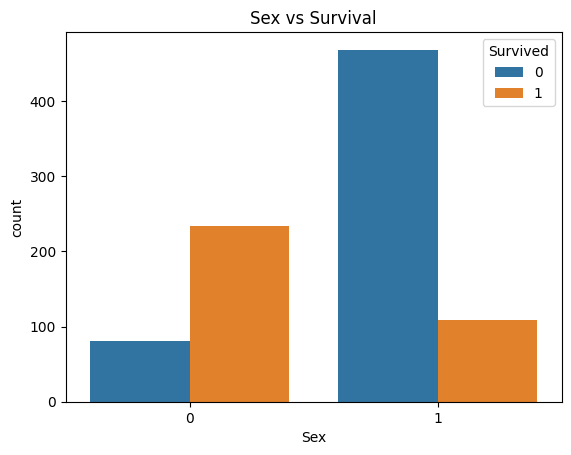

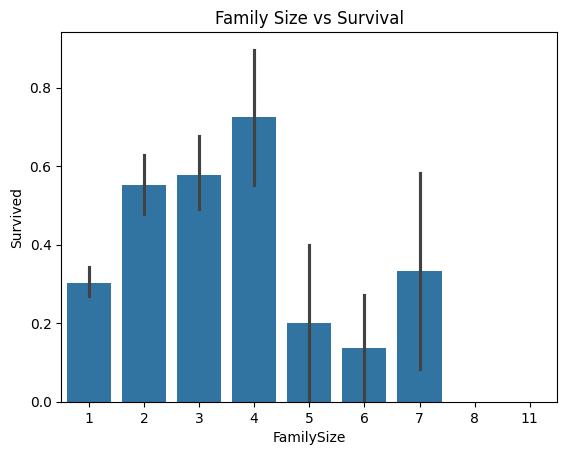

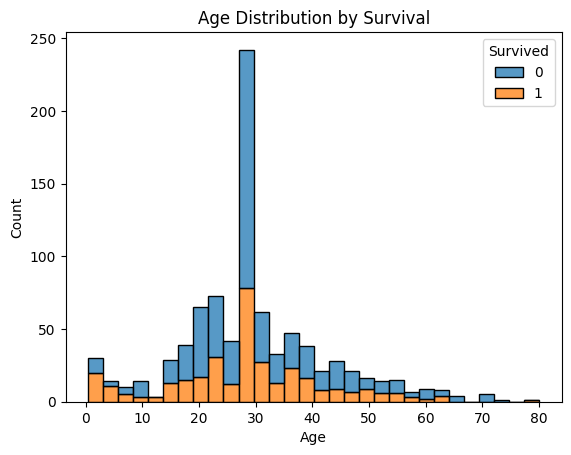

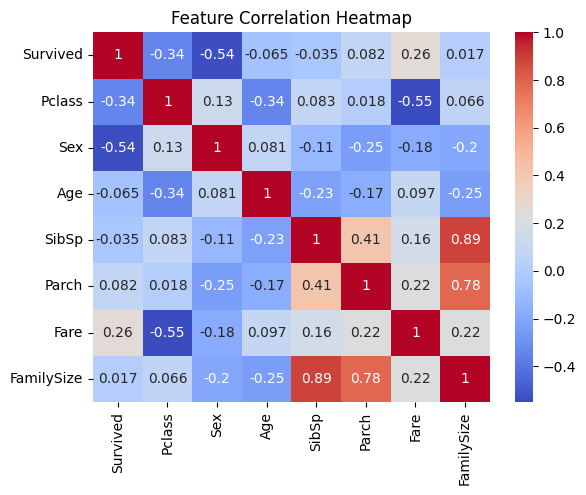

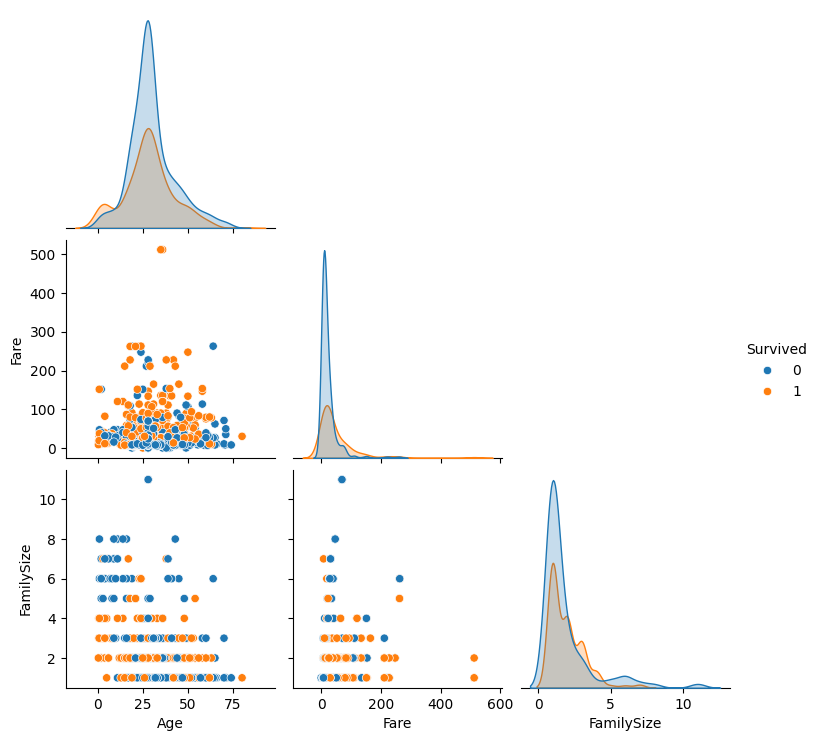

In [33]:
# Survival by Pclass
sns.countplot(x='Pclass', hue='Survived', data=train_data)
plt.title("Passenger Class vs Survival")
plt.show()

# Survival by Sex
sns.countplot(x='Sex', hue='Survived', data=train_data)
plt.title("Sex vs Survival")
plt.show()

# Survival by FamilySize
sns.barplot(x='FamilySize', y='Survived', data=train_data)
plt.title("Family Size vs Survival")
plt.show()

# Age distribution by survival
sns.histplot(data=train_data, x='Age', hue='Survived', multiple='stack', bins=30)
plt.title("Age Distribution by Survival")
plt.show()

# Correlation heatmap
corr = train_data[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','FamilySize']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Pairplot for numeric features
sns.pairplot(train_data[['Age','Fare','FamilySize','Survived']], hue='Survived', corner=True)
plt.show()

Validation Accuracy: 0.8156424581005587


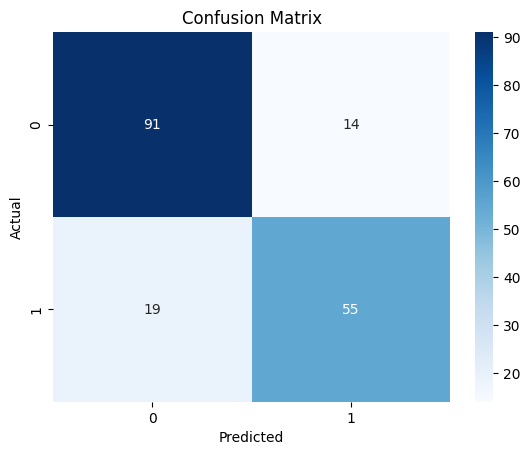

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179



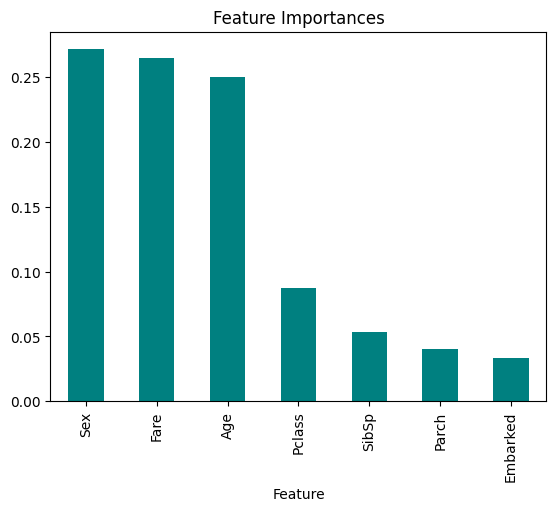

In [35]:
# Accuracy
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(y_val, y_pred))

# Feature importance
importances = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)
importances.plot(kind='bar', x='Feature', y='Importance', legend=False, color='teal')
plt.title("Feature Importances")
plt.show()

In [37]:
# Predict on test set
test_predictions = model.predict(test_X)

# Create submission file
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('titanic_submission.csv', index=False)
print("✅ Submission saved as titanic_submission.csv")

✅ Submission saved as titanic_submission.csv
